In [858]:
import cv2
import numpy as np
import csv
import pandas as pd
from datetime import datetime
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET
import glob
import os
import re

In [859]:
score_title="Rock-ver"

SAVE_IMAGE_PATH="../data/segment-img"
STAVE = "staves"
RESIZED_STAVE = "resized-staves"
SAVE_FEATURE_PATH="../data/feature"
STAVE_FEATURE = "stave-feature" 

## 이미지 전처리

이진화 및 변수 지정

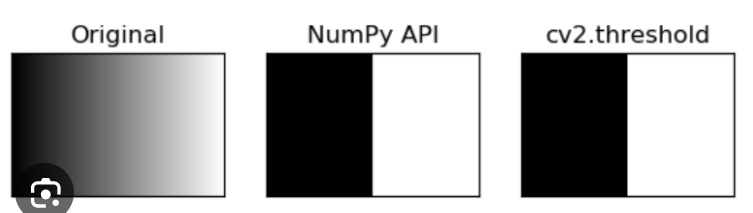

In [860]:
def transform_img2binaryimg(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

In [861]:
def get_score_info(score_path):
    gray = transform_img2binaryimg(score_path)
    ret, gray = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    # binary_img = cv2.bitwise_and(img, img, mask = gray) # 원본이미지와 바이너리 이미지를 엔드연산하는 코드 
    height, width = gray.shape
    return gray, height, width

보표 추출

In [862]:
def transform_score2segment(gray):
    # mask = np.zeros(gray.shape, np.uint8)
    """
    객체 정보를 함께 반환하는 레이블링 함수
    cnt : 객체 수 + 1 (배경 포함)
    labels : 객체에 번호가 지정된 레이블 맵
    stats : N행 5열, N은 객체 수 + 1이며 각각의 행은 번호가 지정된 객체를 의미, 5열에는 x, y, width, height, area 순으로 정보가 담겨 있습니다. x,y 는 좌측 상단 좌표를 의미하며 area는 면적, 픽셀의 수를 의미합니다.
    centroids : N행 2열, 2열에는 x,y 무게 중심 좌표가 입력되어 있습니다. 무게 중심 좌표는 픽셀의 x 좌표를 다 더해서 갯수로 나눈 값입니다. y좌표도 동일합니다.
    """
    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(gray)
    return cnt, labels, stats, centroids

In [863]:
def save_stave_img(cnt, stats, width, gray):
    # -- idx:0은 배경이라 제외
    for i in range(1, cnt):
        date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        x, y, w, h, area = stats[i]
        # width : 1700
        # 1700 * 0.5 = 850
        # -- 길이가 오선지 길이일 때만,,,
        if w > width * 0.5:
            roi = gray[y:y+h, x:x+w]
            cv2.imwrite(f"{SAVE_IMAGE_PATH}/{STAVE}/{score_title}-{STAVE}-{i}-{date_time}.png", roi)
            print(roi)

stave image 저장

In [864]:
# gray, height, width = get_score_info("../data/raw/Rock-ver/Rock-ver-3.png")
# cnt, labels, stats, centroids = transform_score2segment(gray)
# save_stave_img(cnt, stats, width, gray)

In [865]:

def get_all_imgs(img_folder_path):
    file_list = glob.glob(f"{img_folder_path}/*")
    file_list_png = [file for file in file_list if file.endswith(".png")]
    return file_list_png

In [866]:
STAVE_HEIGHT = 100
PAD_WIDTH = 1700

def resize_stave_img(image_path):
    image = Image.open(image_path)
    # resize 수행
    width_percent = (STAVE_HEIGHT / float(image.size[1]))
    new_width = int((float(image.size[0]) * float(width_percent)))
    resized_image = image.resize((new_width, STAVE_HEIGHT))
    # right padding 추가
    if resized_image.width < PAD_WIDTH:
        padding_width = PAD_WIDTH - resized_image.width
        padding = (0, 0, padding_width, 0)
        resized_image = ImageOps.expand(resized_image, padding, fill='black')
    
    return resized_image

In [867]:
# height 100 resize 하면서 width padding도 채우기
def resize_stave_imgs(image_paths):
    for image in image_paths:
        file_name=os.path.basename(image)
        # 정규표현식을 사용하여 날짜 부분 추출
        date_pattern = r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}'
        match = re.search(date_pattern, file_name)
        if match:
            date_string = match.group()
        else:
            date_string = None
        new_file_name = file_name.replace(f"{STAVE}", f"{RESIZED_STAVE}")
        date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        new_file_name = new_file_name.replace(date_string, date_time)

        resized_image = resize_stave_img(image)
        resized_image.save(f"{SAVE_IMAGE_PATH}/{RESIZED_STAVE}/{new_file_name}")

resize stave image's heigth 100, width 1700

In [868]:
# imgs = get_all_imgs(f"{SAVE_IMAGE_PATH}/{STAVE}/")
# resize_stave_imgs(imgs)

In [869]:
def extract_imgs_feature(resized_imgs):
    features=[]
    for resize_img in resized_imgs:
        gray = transform_img2binaryimg(resize_img)
        features.append(gray)
        print(gray.shape)
    return features

In [870]:
def save_feature_csv(features):
    date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_path = f"{SAVE_FEATURE_PATH}/{STAVE_FEATURE}-{date_time}.csv"
    df = pd.DataFrame(features)
    df.to_csv(save_path, index=False, header=False)

csv 파일로 저장

In [871]:
# resized_imgs = get_all_imgs(f"{SAVE_IMAGE_PATH}/{RESIZED_STAVE}/")
# features = extract_imgs_feature(resized_imgs)

# # 데이터 이어붙이기
# merged_data = np.concatenate(features, axis=1)

# # 전치
# transposed_data = np.transpose(merged_data)

# save_feature_csv(transposed_data)

In [872]:
cv2.waitKey(0)
cv2.destroyAllWindows()

## XML 라벨링

In [873]:
def load_xml_data(file_path: str):
    """
    xml data 불러오기
    """
    try:
        tree = ET.parse(file_path)  # XML 파일을 파싱
        root = tree.getroot()
        return root
    except ET.ParseError as e:
        print(f"XML 파일을 파싱하는 동안 오류가 발생했습니다: {e}")
        return None

In [874]:
def extract_pitch(xml_file):
    """
    multiple pitch 추출
    <chord/> <-  얘 있으면 동시에 친 거임
    <pitch>
        <step>A</step>
        <octave>5</octave>
    </pitch>

    output : [['G5'], ['G5'], ['G5'], ['C5'], ['C5'], ['F4', 'A5'], ...]
    """
    def extract_step_octave(pitch_element):
        """
        step, octave 추출
        <pitch>
            <step>C</step>
            <octave>5</octave>
        </pitch>
        """
        step = pitch_element.find('step').text
        octave = pitch_element.find('octave').text
        return step, octave
    
    # XML 파일 파싱
    root = load_xml_data(xml_file)
    
    pitch_list = []
    chord_list = []

    # 모든 <note> 엘리먼트를 찾습니다.
    for note in root.iter('note'):
        pitch_elements = note.findall('./pitch')
        # <chord> 엘리먼트를 가진 <note> 엘리먼트인지 확인
        is_chord = note.find('chord') is not None
        # 만약 <chord> 엘리먼트를 가진 <note> 엘리먼트라면, 계속 추가
        if is_chord:
            for pitch_element in pitch_elements:
                step, octave = extract_step_octave(pitch_element)
                chord_list.append(step + octave)
        else:
            for pitch_element in pitch_elements:
                step, octave = extract_step_octave(pitch_element)
                chord_list = [] # -- 초기화
                chord_list.append(step + octave)
                pitch_list.append(chord_list)
    
    return pitch_list

In [875]:
# XML 파일 경로
# xml_file_path = '../data/raw/Rock-ver.xml'
# pitches = extract_pitch(xml_file_path)

# # 결과를 출력합니다.
# for i, pitches in enumerate(pitches, 1):
#     print(f"Note {i}: {' '.join(pitches)}")

binary img에서 음표 하나라도 인식되면 세로로 줄 긋기

In [876]:
def get_score_remove_stave(score_path):
    """
    보표 제거한 score 얻기
    """
    gray, height, width = get_score_info(score_path)
    cnt, labels, stats, centroids = transform_score2segment(gray) # 모든 객체 검출하기

    mask = np.zeros(gray.shape, np.uint8)
    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(gray)

    # -- stave
    for i in range(1, cnt):
        x, y, w, h, area = stats[i]
        if w > width * 0.5:
            cv2.rectangle(mask, (x, y, w, h), (255, 255, 255), -1)
    masked = cv2.bitwise_and(gray, mask)
    staves = []
    for row in range(height):
        pixels = 0
        for col in range(width):
            pixels += (masked[row][col] == 255)
        if pixels >= width * 0.5:
            if len(staves) == 0 or abs(staves[-1][0] + staves[-1][1] - row) > 1:
                staves.append([row, 0])
            else:
                staves[-1][1] += 1

    for staff in range(len(staves)):
        top_pixel = staves[staff][0]
        bot_pixel = staves[staff][0] + staves[staff][1]
        for col in range(width):
            if height-staves[staff][1] > bot_pixel and masked[top_pixel - 1][col] == 0 and masked[bot_pixel + 1][col] == 0:
                for row in range(top_pixel, bot_pixel + 1):
                    masked[row][col] = 0
                    
    # date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # cv2.imwrite(f"{SAVE_IMAGE_PATH}/scores/{score_title}-score-{date_time}.png", 255-masked)
    return masked

In [877]:
src="../data/raw/Rock-ver/Rock-ver-1.png"
masked = get_score_remove_stave(src)

In [878]:
image = cv2.imread(src)

# Contour
# RETR_EXTERNAL: 그림의 외곽 부분에만 컨투어를 그림
contours, hierarchy = cv2.findContours(masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

masked_copy=255-masked

# i=1
# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     # -- 여기서 음표만 추출할 수 있도록 길이 설정... 하드코딩이라 방법 생각해내야 함.
#     if (w>10 and w<=30) and (h>10): 
#         roi = masked_copy[y:y+h, x:x+w]
#         # cv2.imwrite('../data/segment-img/segments/save%s.jpg' %i, roi)
#     i+=1

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    
    # # 꼬리가 있는 음표는 가로 세로 비율이 작은 경우로 가정
    # # if aspect_ratio < 0.5:
    # # 꼬리의 방향에 따라 stem 결정
    # if w < h:  # 세로로 긴 꼬리
    #     stem_x = x + w // 2
    #     stem_y1 = y + h // 2
    #     stem_y2 = y + h
    # else:     # 가로로 긴 꼬리
    #     stem_x = x + w
    #     stem_y1 = y + h // 2
    #     stem_y2 = y + h
    # cv2.rectangle(image, (stem_x, stem_y1), (stem_x, stem_y2), (0, 0, 255), 2)
    # if (w>10 and w<=30) and (h>10):
    cv2.rectangle(image, (x,y,w,h), (0, 0, 255), 2)

# masked_copy=cv2.drawContours(masked_copy, contours, -1, (255, 0, 0), 3)
date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
cv2.imwrite(f"{SAVE_IMAGE_PATH}/scores/{score_title}-score-{date_time}.png", image)

True

In [879]:
# img = cv2.imread(src)
# img2 = img.copy()
# # 바이너리 이미지로 변환
# imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, imthres = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

# # 가장 바깥 컨투어만 수집   --- ①
# contour, hierarchy = cv2.findContours(imthres, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
# cv2.drawContours(img, contour, -1, (0,255,0), 3)

# date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# cv2.imwrite(f"{SAVE_IMAGE_PATH}/segments/{score_title}-segment-{date_time}.png", img)

In [880]:
cv2.waitKey(0)
cv2.destroyAllWindows()